## Import Libraries

In [1]:
# Core PyTorch library - the main framework for building neural networks
import torch
import torch.nn as nn  # nn = neural network building blocks
import torch.optim as optim  # Optimization algorithms (the "teacher" that corrects mistakes)


# For loading datasets and transforming images
import torchvision
import torchvision.transforms as transforms

# For visualizing our data and results
import matplotlib.pyplot as plt

# For numerical operations
import numpy as np

In [2]:
# Check if we're using CPU or GPU (in your case, it'll be CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Set random seed for reproducibility (so results are consistent each time)
torch.manual_seed(42)
np.random.seed(42)

print("✅ All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")

Using device: cpu
✅ All libraries imported successfully!
PyTorch version: 2.9.0+cu128


## Load Raw Dataset

In [3]:
print("=" * 50)
print("EXPLORATORY DATA ANALYSIS (EDA)")
print("=" * 50)

# Download the dataset WITHOUT any transformations first
# We only convert to tensor (no normalization yet) so we can see raw pixel values
raw_transform = transforms.Compose([
    transforms.ToTensor()  # Just convert to tensor, keep original 0-1 range
])

# Load datasets
# train dataset
train_dataset_raw = torchvision.datasets.FashionMNIST(
    root='../data', 
    train=True, 
    download=True, 
    transform=raw_transform
)
# test dataset
test_dataset_raw = torchvision.datasets.FashionMNIST(
    root='../data', 
    train=False, 
    download=True, 
    transform=raw_transform
)

print("✅ Dataset downloaded successfully!")
print(f"{train_dataset_raw.data.shape}")
print(f"{test_dataset_raw.data.shape}")

EXPLORATORY DATA ANALYSIS (EDA)
✅ Dataset downloaded successfully!
torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


## Basic Information

In [4]:
# BASIC INFORMATION

# What we're checking:
# - How many images do we have?
# - What size are the images? (28×28 pixels)
# - What format is the data in? (tensors)
# - How many categories? (10 clothing types)

# Label = shows the real type and value of the data
# (in the dataset as how they are stored - not like this is an image or an ankle boot)

# Label Number  →  Clothing Type
# ─────────────────────────────
# 0             →  T-shirt/top
# 1             →  Trouser
# 2             →  Pullover
# 3             →  Dress
# 4             →  Coat
# 5             →  Sandal
# 6             →  Shirt
# 7             →  Sneaker
# 8             →  Bag
# 9             →  Ankle boot

print("\n📊 DATASET OVERVIEW:")
print("-" * 50)
print(f"Training samples: {len(train_dataset_raw):,}")
print(f"Test samples: {len(test_dataset_raw):,}")
print(f"Total samples: {len(train_dataset_raw) + len(test_dataset_raw):,}")

# Get one sample to inspect
sample_image, sample_label = train_dataset_raw[0]
print(f"\nImage shape: {sample_image.shape}")  # Should be [1, 28, 28]
print(f"Image data type: {sample_image.dtype}")
print(f"Label type: {type(sample_label)}")
print(f"Label value: {sample_label}")

# Class names
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
print(f"\nNumber of classes: {len(classes)}")
print(f"Class names: {classes}")

# Results show that we have a total of 70 000 images to work with.
# The images one by one are only 2D with the channel of grayscale hence the dimensions [1, 28, 28],
# which translates to 28 by 28 pixel size by each individual image.
# There are 10 categories corresponding with the dataset indices of labels.


📊 DATASET OVERVIEW:
--------------------------------------------------
Training samples: 60,000
Test samples: 10,000
Total samples: 70,000

Image shape: torch.Size([1, 28, 28])
Image data type: torch.float32
Label type: <class 'int'>
Label value: 9

Number of classes: 10
Class names: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


## Visualize Sample Images


🖼️  SAMPLE IMAGES FROM EACH CLASS:


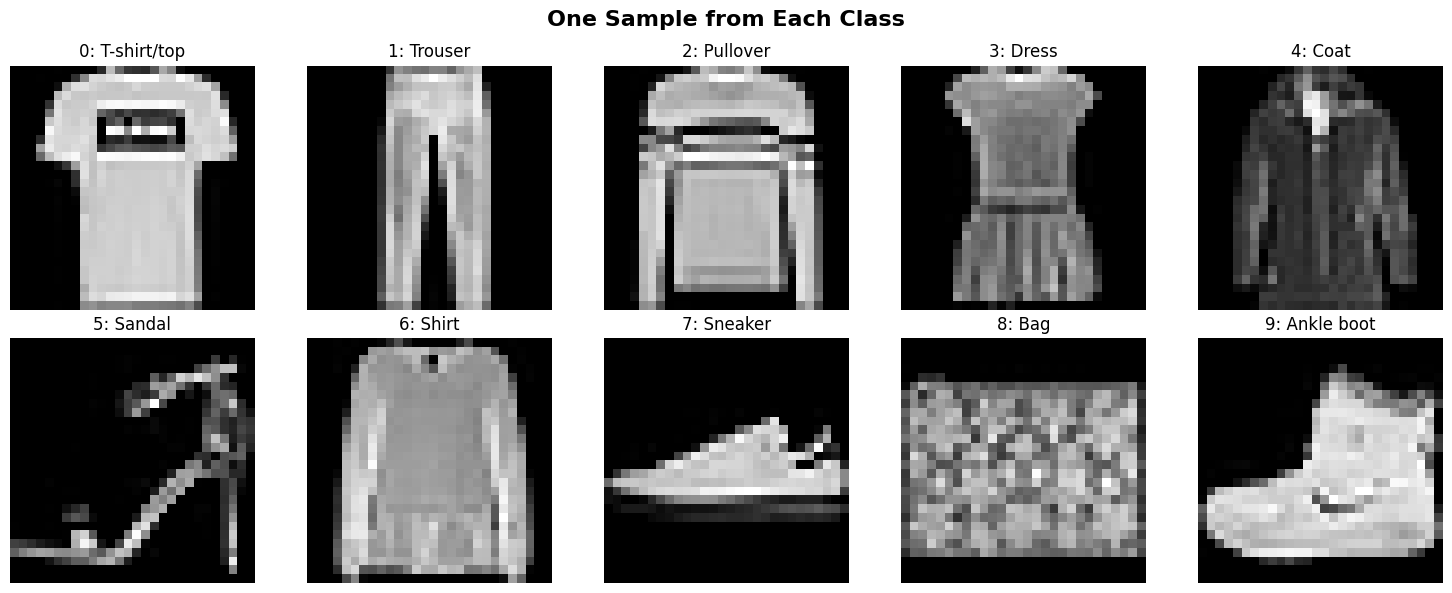

In [5]:
# VISUALIZE SAMPLES FOR REASSURANCE

# What we're checking:
# - What does each clothing type actually look like?
# - Are the images clear enough?
# - Do the labels make sense?


# Let's look at random samples from each class
print("\n🖼️  SAMPLE IMAGES FROM EACH CLASS:")

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('One Sample from Each Class', fontsize=16, fontweight='bold')

for idx, class_name in enumerate(classes):
    # Find first image of this class
    for i in range(len(train_dataset_raw)):
        img, label = train_dataset_raw[i]
        if label == idx:
            # Plot it
            row = idx // 5
            col = idx % 5
            axes[row, col].imshow(img.squeeze(), cmap='gray')
            axes[row, col].set_title(f'{idx}: {class_name}')
            axes[row, col].axis('off')
            break

plt.tight_layout()
plt.show()

# Result show all the images are greyscaled and based on black background and the labels make sense.
# As for the image quality in my opinion it is totally okay as we can tell them apart and define what
# we are seeing (no ambiguity).

## Class Distribution Analysis


📈 CLASS DISTRIBUTION ANALYSIS:

Training Set Distribution:
--------------------------------------------------
Class           Name            Count      Percentage
--------------------------------------------------
0               T-shirt/top     6000       10.0%
1               Trouser         6000       10.0%
2               Pullover        6000       10.0%
3               Dress           6000       10.0%
4               Coat            6000       10.0%
5               Sandal          6000       10.0%
6               Shirt           6000       10.0%
7               Sneaker         6000       10.0%
8               Bag             6000       10.0%
9               Ankle boot      6000       10.0%

Test Set Distribution:
--------------------------------------------------
Class           Name            Count      Percentage
--------------------------------------------------
0               T-shirt/top     1000       10.0%
1               Trouser         1000       10.0%
2               

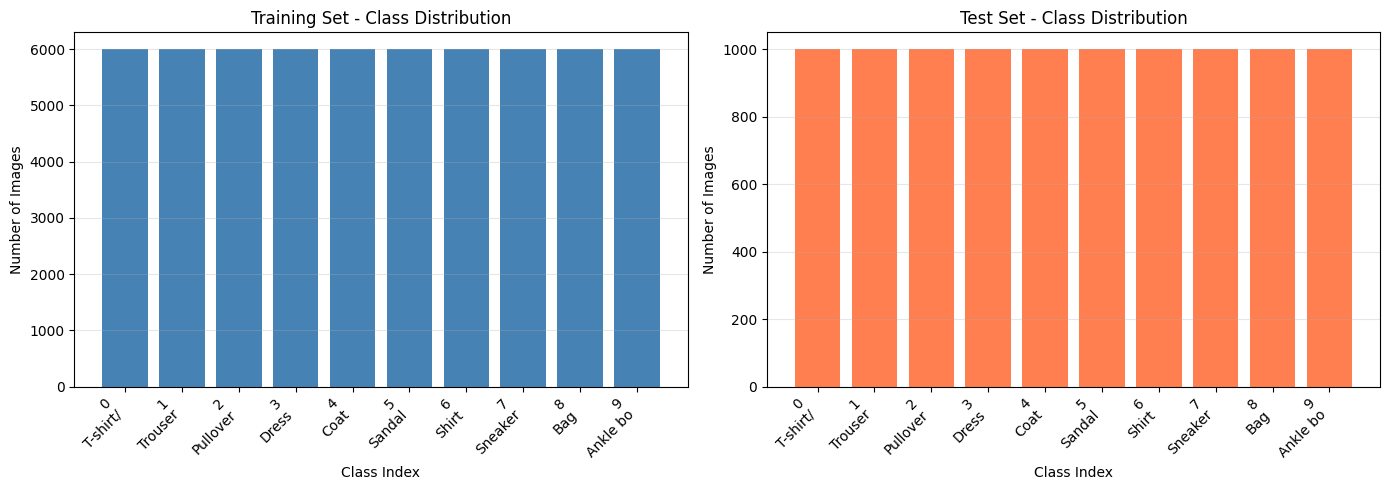

In [6]:
# CLASS DISTRIBUTION FOR BALANCE CHECK

# What we're checking:
# - Are all classes equally represented? (balanced dataset?)
# - If one class has way more examples, the model might be biased towards it
# - Fashion-MNIST is balanced (6000 per class in training), but good to verify!

print("\n📈 CLASS DISTRIBUTION ANALYSIS:")

# Count how many images per class
train_labels = [label for _, label in train_dataset_raw]
test_labels = [label for _, label in test_dataset_raw]

# Count occurrences
from collections import Counter

train_counts = Counter(train_labels)
test_counts = Counter(test_labels)

# Print table
print("\nTraining Set Distribution:")
print("-" * 50)
print(f"{'Class':<15} {'Name':<15} {'Count':<10} {'Percentage':<10}")
print("-" * 50)
for class_idx in range(10):
    count = train_counts[class_idx]
    percentage = (count / len(train_dataset_raw)) * 100
    print(f"{class_idx:<15} {classes[class_idx]:<15} {count:<10} {percentage:.1f}%")

print("\nTest Set Distribution:")
print("-" * 50)
print(f"{'Class':<15} {'Name':<15} {'Count':<10} {'Percentage':<10}")
print("-" * 50)
for class_idx in range(10):
    count = test_counts[class_idx]
    percentage = (count / len(test_dataset_raw)) * 100
    print(f"{class_idx:<15} {classes[class_idx]:<15} {count:<10} {percentage:.1f}%")

# Visualize distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Training distribution
ax1.bar(range(10), [train_counts[i] for i in range(10)], color='steelblue')
ax1.set_xlabel('Class Index')
ax1.set_ylabel('Number of Images')
ax1.set_title('Training Set - Class Distribution')
ax1.set_xticks(range(10))
ax1.set_xticklabels([f'{i}\n{classes[i][:8]}' for i in range(10)], rotation=45, ha='right')
ax1.grid(axis='y', alpha=0.3)

# Test distribution
ax2.bar(range(10), [test_counts[i] for i in range(10)], color='coral')
ax2.set_xlabel('Class Index')
ax2.set_ylabel('Number of Images')
ax2.set_title('Test Set - Class Distribution')
ax2.set_xticks(range(10))
ax2.set_xticklabels([f'{i}\n{classes[i][:8]}' for i in range(10)], rotation=45, ha='right')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Results show we are good as there is not a single problem with the distribution of the data
# (nothing missing or lacking in amount for all the labels, no possible bias towards any class - same values).

## Image Consistency Check

In [7]:
# VERIFY IMAGE CONSISTENCY

# What we're checking:
# - Are all images the same size? (important for neural networks!)
# - Grayscale (1 channel) or color (3 channels)?

print("\n✅ IMAGE CONSISTENCY CHECK:")

# Check if all images have the same dimensions
all_same = True
expected_shape = (1, 28, 28)

for i in range(min(100, len(train_dataset_raw))):  # Check first 100
    img, _ = train_dataset_raw[i]
    if img.shape != expected_shape:
        print(f"❌ Image {i} has unexpected shape: {img.shape}")
        all_same = False
        break

if all_same:
    print(f"✅ All images have consistent shape: {expected_shape}")
    print(f"   - Channels: {expected_shape[0]}")
    print(f"   - Height: {expected_shape[1]} pixels")
    print(f"   - Width: {expected_shape[2]} pixels")
    print(f"   - Total pixels per image: {28*28} should equal to 784")


✅ IMAGE CONSISTENCY CHECK:
✅ All images have consistent shape: (1, 28, 28)
   - Channels: 1
   - Height: 28 pixels
   - Width: 28 pixels
   - Total pixels per image: 784 should equal to 784


## Pixel Value Analysis


🔢 PIXEL VALUE STATISTICS:

Analyzed 1000 random images
Total pixels analyzed: 784,000
Supposed amount of analysed pixels: 784000

Analyzed 1000 random images
Total pixels analyzed: 784,000
Supposed amount of analysed pixels: 784000
Min pixel value: 0.0000
Max pixel value: 1.0000
Mean pixel value: 0.2826
Std deviation: 0.3523
Median: 0.0000
Min pixel value: 0.0000
Max pixel value: 1.0000
Mean pixel value: 0.2826
Std deviation: 0.3523
Median: 0.0000


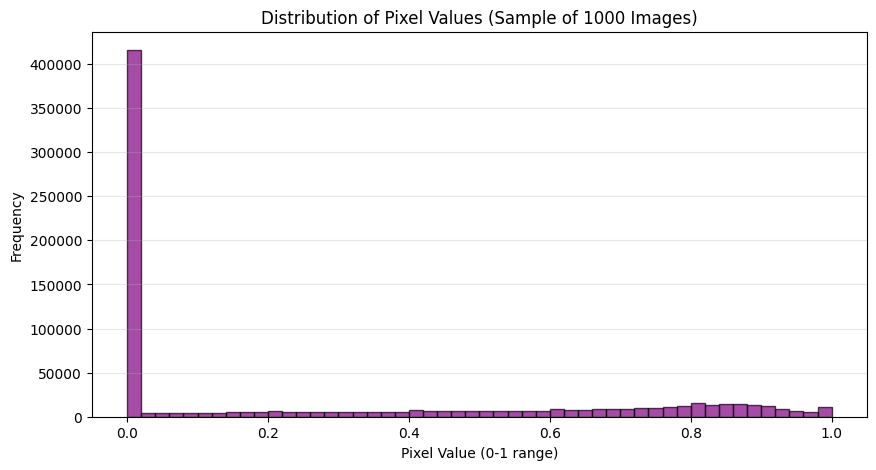

In [8]:
# PIXEL VALUE ANALYSIS

# What we're checking:
# - What range are pixel values in? (0-1 range)
# - What's the average brightness?
# - Are most pixels dark or light?
# - This tells us HOW to normalize in the next section!

print("\n🔢 PIXEL VALUE STATISTICS:")

# Sample 1000 random images to analyze
sample_size = 1000
sample_indices = np.random.choice(len(train_dataset_raw), sample_size, replace=False)

pixel_values = []
for idx in sample_indices:
    img, _ = train_dataset_raw[idx]
    pixel_values.extend(img.flatten().numpy()) # flatten?

pixel_values = np.array(pixel_values)

print(f"\nAnalyzed {sample_size} random images")
print(f"Total pixels analyzed: {len(pixel_values):,}")
print(f"Supposed amount of analysed pixels: {1000*(28*28)}") # intentionally hard-coded
print(f"Min pixel value: {pixel_values.min():.4f}")
print(f"Max pixel value: {pixel_values.max():.4f}")
print(f"Mean pixel value: {pixel_values.mean():.4f}")
print(f"Std deviation: {pixel_values.std():.4f}")
print(f"Median: {np.median(pixel_values):.4f}")

# Plot histogram
plt.figure(figsize=(10, 5))
plt.hist(pixel_values, bins=50, color='purple', alpha=0.7, edgecolor='black')
plt.xlabel('Pixel Value (0-1 range)')
plt.ylabel('Frequency')
plt.title('Distribution of Pixel Values (Sample of 1000 Images)')
plt.grid(axis='y', alpha=0.3)
plt.show()

# Results show most pixel values are close to 0 - logical cause we have grayscale images with based black background.
# The correct amount of analyzed pixels should be counted by the following mathematical logic:
# We get a 1000 image and each image is a 28 by 28 pixel thus amount_of_images * (each_individual_image_total_pixel_size)
# The average pixel brightness is the "Mean pixel value".

## EDA Summary

In [9]:
# EDA SUMMARY

print("\n" + "=" * 50)
print("EDA SUMMARY")
print("=" * 50)
print(f"Training samples: {len(train_dataset_raw):,}")
print(f"Test samples: {len(test_dataset_raw):,}")
print(f"Total samples: {len(train_dataset_raw) + len(test_dataset_raw):,}")
print(f"✅ All images have consistent shape: {expected_shape}")
print(f"   - Channels: {expected_shape[0]}")
print(f"   - Height: {expected_shape[1]} pixels")
print(f"   - Width: {expected_shape[2]} pixels")
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
print(f"Number of classes: {len(classes)}")
print(f"Class names: {classes}")


EDA SUMMARY
Training samples: 60,000
Test samples: 10,000
Total samples: 70,000
✅ All images have consistent shape: (1, 28, 28)
   - Channels: 1
   - Height: 28 pixels
   - Width: 28 pixels
Number of classes: 10
Class names: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
